In [1]:
import torch
import torchvision
from mmpose.apis.inference import init_model, init_default_scope
from matplotlib import pyplot as plt
from mmengine import Config
from mmpose.models.heads import RTMCCHead
from mmpose.models import TopdownPoseEstimator
from mmpose.apis import Pose2DInferencer, inference_topdown
from mmpose.models.backbones.cspnext import CSPNeXt
from mmpose.codecs.simcc_label import SimCCLabel
import sys

sys.path.append('/root/projects/sign_language_transformer/src')
import csi_sign_language.modules.tcformer_module.tcformer_mmpose

ckpt = '/root/projects/sign_language_transformer/resources/dwpose-l/dw-ll_ucoco.pth'
cfg = '/root/projects/sign_language_transformer/resources/tcformer/tcformer_mta_coco_wholebody_256x192.py'
device = 'cuda:1'
image = '../resources/test_image.png'

cfg = Config.fromfile(cfg)
init_default_scope('mmpose')
model: TopdownPoseEstimator = init_model(cfg, None, device=device)

std = torch.tensor(cfg.model.data_preprocessor.std)
mean = torch.tensor(cfg.model.data_preprocessor.mean)

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


TypeError: TopdownPoseEstimator.__init__() got an unexpected keyword argument 'pretrained'

# Prepare example data

data type: uint8


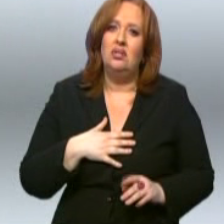

In [2]:
#prepare data
from PIL import Image
import numpy as np

def central_crop(image, crop_width, crop_height):
    # Get the dimensions of the image
    img_width, img_height = image.size

    # Calculate the coordinates for the central crop
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = (img_width + crop_width) / 2
    bottom = (img_height + crop_height) / 2

    # Perform the crop
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

image = Image.open('../resources/test_image.png')
image = central_crop(image, 224, 224)
print(f'data type: {np.array(image).dtype}')
image

In [3]:
#preprocess the data
import einops
data = torch.from_numpy(np.array(image)).float()
data = (data - std) / mean
print(f'std: {data.std()}, mean: {data.mean()}')

data = einops.rearrange(data, '(n h) w c -> n c h w', n=1).to(device)
print(f'data shape {data.shape}')

#affine and padding
data = torch.nn.functional.interpolate(data, (192, 192), mode='bilinear')
data = torch.nn.functional.pad(data, [0, 0, 0, 64])

print(f'data after affine {data.shape}')

std: 0.6731945276260376, mean: 0.4586787223815918
data shape torch.Size([1, 3, 224, 224])
data after affine torch.Size([1, 3, 256, 192])


# Inference Using inference_topdown(model, image)

In [4]:
result = inference_topdown(model ,np.array(image))

# Inference Using directly tensor inputs

In [5]:
with torch.no_grad():
    y, x = model(data, None, 'tensor')
    y, x = (torch.squeeze(a, 0) for a in (y, x))
    y, x = (torch.nn.functional.softmax(a, dim=0) for a in (y, x))
    print(f'output size: {y.shape} and {x.shape}')
    map = einops.einsum(y, x, 'k y, k x -> k x y')
    map = torch.max(map, dim=0)[0]
    # map = map[2]
    # map = torch.where(map < 0.01, torch.zeros_like(map), map)

    #cut-off the padding edge and remap the position
    map = torch.nn.functional.interpolate(map.unsqueeze(0).unsqueeze(0), [256, 192])[0, 0]
    map = map[:-64, :]
    map = torch.nn.functional.interpolate(map.unsqueeze(0).unsqueeze(0), [224, 224])[0, 0]


output size: torch.Size([133, 384]) and torch.Size([133, 512])


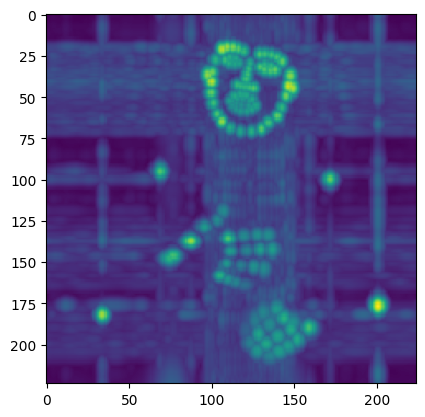

In [6]:
with torch.no_grad():
    max = torch.max(map)
    min = torch.min(map)
    # map = (map - min) / (max - min)
    # map = torch.nn.functional.interpolate(map.unsqueeze(0).unsqueeze(0), [48, 48], mode='bilinear')[0, 0]

plt.imshow(map.cpu().numpy())

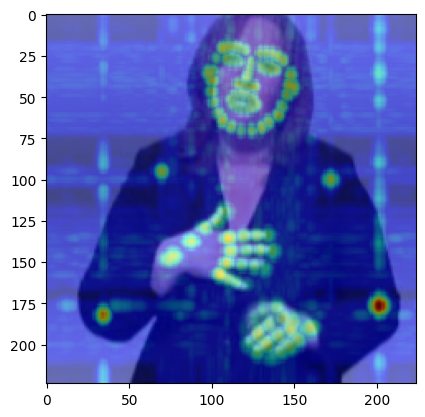

In [43]:
def apply_colormap(heatmap):
    """Apply a colormap to the heatmap and normalize."""
    cmap = plt.get_cmap('jet')
    heatmap_colored = cmap(heatmap)  # Apply colormap
    return heatmap_colored[..., :3]  # Discard alpha channel

def blend_images(base_img, overlay_img, alpha=0.5):
    """Blend the base image with the overlay image."""
    return (1 - alpha) * base_img + alpha * overlay_img

# plt.imshow(map.cpu().numpy())

origin = np.array(image, dtype='float32')/255.0
heatmap = apply_colormap(map.cpu().numpy())
blend_image = blend_images(origin, heatmap, alpha=0.5)
plt.imshow(blend_image)